# mofashion
multi-label image categorization

We have four classes:
* models with the piece of clothing in full view
* models with the piece of clothing partially visible
* the piece of clothing only, in full view
* the piece of clothing only, partially visible

We use FastAI to train a preconfigured Resnext 50 model.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import os.path
import sys

import numpy as np
import matplotlib
from sklearn import metrics

In [3]:
sys.path.insert(0, r'C:\Users\Mo\fastai\old')
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

ImportError: DLL load failed: A dynamic link library (DLL) initialization routine failed.

In [4]:
torch.cuda.set_device(0)
print(torch.cuda.is_available(), torch.backends.cudnn.enabled)

True True


In [5]:
PATH = r'F:\mofashion-data'
sz = 224  # image size
bs = 20   # batch size, low enough so architecture fits in memory
arch = resnext50

In [6]:
classes = {'models-full': 0, 'models-partial': 1, 'items-full': 2, 'items-partial': 3}
n_classes = 4

In [31]:
count = {'models-full': 0, 'models-partial': 0, 'items-full': 0, 'items-partial': 0}
fnames = []
y = []
for root, dirs, filenames in os.walk(PATH):
    if root == PATH or 'tmp' in root:
        continue
    if sum([1 for char in root if char == '-']) < 3:
        continue
    folder = os.path.split(root)[1]
    print(root, '     ', folder)
    shop, gender, class1, class2 = folder.split('-')
    for filename in filenames:
        assert filename.endswith('.jpeg')
        start = filename.split('_')[0]
        assert start == folder
        file_class = f'{class1}-{class2}'
        count[file_class] += 1
        fnames.append(os.path.join(folder, filename))
        y.append(classes[file_class])
assert len(fnames) == len(y)
y = np.array(y)
count

F:\mofashion-data\hm-f-items-full       hm-f-items-full
F:\mofashion-data\hm-f-models-full       hm-f-models-full
F:\mofashion-data\hm-f-models-partial       hm-f-models-partial
F:\mofashion-data\hm-m-items-full       hm-m-items-full
F:\mofashion-data\hm-m-items-partial       hm-m-items-partial
F:\mofashion-data\hm-m-models-full       hm-m-models-full
F:\mofashion-data\hm-m-models-partial       hm-m-models-partial
F:\mofashion-data\ma-f-items-full       ma-f-items-full
F:\mofashion-data\ma-f-models-full       ma-f-models-full
F:\mofashion-data\ma-f-models-partial       ma-f-models-partial
F:\mofashion-data\ma-m-items-full       ma-m-items-full
F:\mofashion-data\ma-m-models-full       ma-m-models-full
F:\mofashion-data\ma-m-models-partial       ma-m-models-partial
F:\mofashion-data\un-f-items-full       un-f-items-full
F:\mofashion-data\un-f-items-partial       un-f-items-partial
F:\mofashion-data\un-f-models-full       un-f-models-full
F:\mofashion-data\un-f-models-partial       un-f-m

{'models-full': 8166,
 'models-partial': 2866,
 'items-full': 5568,
 'items-partial': 1734}

In [32]:
max(count.values()) / min(count.values())

4.709342560553633

In [33]:
n = sum(count.values())
n

18334

## Undersampling
Our dataset is not balanced. There are not that many partial items, and way more full models.
The most straight-forward way to deal with this is undersampling. Since I'm short on time I'll use that for now.
Since an earlier trial showed that the difference between full and partial items is not that hard, but the same difference for models is hard, I'm using the number of partial models as lowest sample size.

In [34]:
n_per_class = min(count.values())
print('number of items per class should be', n_per_class)
n_per_class = count['models-partial']; n_per_class

number of items per class should be 1734


2866

[2866, 2866, 2866, 1734]


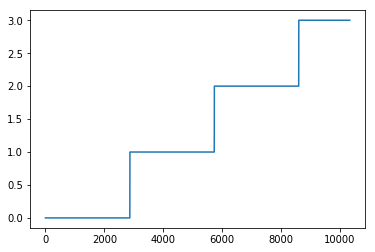

In [35]:
fnames_undersampled = []
y_undersampled = []
for i in range(n_classes):
    y_for_class = np.where(y == i)[0]
    idxs_to_y = np.random.permutation(min(n_per_class, len(y_for_class)))
    idxs = list(y_for_class[idxs_to_y])
    for idx in idxs:
        fnames_undersampled.append(fnames[idx])
        y_undersampled.append(y[idx])
y_undersampled = np.array(y_undersampled)
print([np.sum(y_undersampled == i) for i in range(n_classes)])
plt.plot(y_undersampled);

In [36]:
fnames = fnames_undersampled
y = y_undersampled

In [37]:
n = len(y); n

10332

## Validation indices
I wan't them to be balanced, so the same number of images from each shop, gender and class.

For now to keep it simple ignore shop and gender.

In [38]:
def get_val_idxs(cat, val_pct=0.2):
    """Return indices of datapoints to use in validation.
    
    Input cat is the class number
    """
    np.random.seed(42)
    n_val = int(val_pct * n)
    n_per_class = n_val // n_classes
    idxs = np.random.permutation(n_per_class)
    output = list(np.where(y == i)[0][idxs])
    assert np.all(y[output] == i)
    return output

In [39]:
val_idxs = []
for i in range(n_classes):
    val_idxs.extend(get_val_idxs(i, val_pct=0.2))
val_idxs = np.array(val_idxs)
print('training', len(fnames) - len(val_idxs), 'validation', len(val_idxs))

training 8268 validation 2064


## Initial exploration

In [ ]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1)

In [ ]:
data = ImageClassifierData.from_names_and_array(PATH, fnames, y, classes=None,
                                                val_idxs=val_idxs,
                                                test_name=None, num_workers=8, tfms=tfms, bs=bs)

In [ ]:
fn = os.path.join(PATH, data.trn_ds.fnames[0]); fn

In [ ]:
img = PIL.Image.open(fn); img

In [ ]:
# Assert all files exist
for filepath_part in data.trn_ds.fnames:
    assert os.path.exists(os.path.join(PATH, filepath_part)), filepath_part

In [ ]:
size_d = {k: PIL.Image.open(os.path.join(PATH, k)).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)

In [ ]:
plt.hist(row_sz);

In [ ]:
plt.hist(col_sz);

In [ ]:
len(data.trn_ds), len(data.val_ds)

In [ ]:
for i in range(4):
    print(i, np.sum(data.trn_y == i))

In [ ]:
plt.plot(data.trn_y)

## Initial model

In [16]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1)
    data = ImageClassifierData.from_names_and_array(PATH, fnames, y, classes=None, val_idxs=val_idxs,
                                                    test_name=None, num_workers=8, tfms=tfms, bs=bs)
    data.classes = list(classes.keys())
    # Create a new data object with resized images. Models and stuff are also placed in the new folder.
    return data.resize(340, 'tmp') 

### Load data and precomputed model

In [17]:
data = get_data(sz, bs)
# resizing may take a while

In [18]:
# learn.set_data(data)

In [19]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|████████████████████████████████████████████████████████████████████████████████| 415/415 [03:04<00:00,  2.86it/s]


### Find learning rate

In [ ]:
learn.lr_find()

In [ ]:
# plot the loss vs. learning rate
learn.sched.plot()

In [20]:
lr = 2e-3

## Learn

In [21]:
learn.freeze()  # when starting earlier layers are already frozen
learn.fit(lr, 3)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.227642   0.104305   0.969595  
    1      0.162186   0.07861    0.977799                                                                              
    2      0.144804   0.065933   0.97973                                                                               



[array([0.06593]), 0.9797297254722551]

In [22]:
learn.fit(lr, 3)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.121978   0.060951   0.982143  
    1      0.101246   0.061313   0.981178                                                                              
    2      0.102804   0.057027   0.98166                                                                               



[array([0.05703]), 0.981660228438359]

## Results
The functions here can be used again after further learning down this notebook.

['models-full', 'models-partial', 'items-full', 'items-partial']

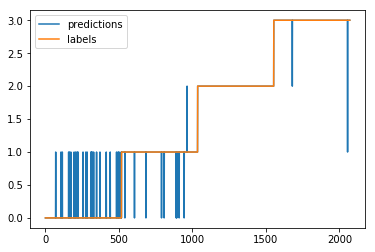

In [23]:
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)
# the probability corresponding to the selected prediction
probs = np.exp(log_preds[np.arange(log_preds.shape[0]), preds])
index = np.argsort(data.val_y)
plt.plot(preds[index], label='predictions')
plt.plot(data.val_y[index], label='labels')
plt.legend()
data.classes

In [24]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, 4, i + 1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
    plt.tight_layout()

def load_img_id(ds, idx):
    return np.array(PIL.Image.open(os.path.join(PATH, ds.fnames[idx])))

def plot_val_with_title(idxs, title, n=4):
    imgs = []
    for x in idxs:
        try:
            imgs.append(load_img_id(data.val_ds, x))
        except FileNotFoundError:
            print('Could not find file', data.val_ds.fnames[x])
    title_probs = ['{} {:.2f}'.format(data.classes[preds[x]], probs[x]) for x in idxs]
    print(title)
    if len(imgs) == 0:
        print('No images to show')
    rows = max(1, n // 4)
    if rows > 1:
        imgs = imgs[:rows * 4]
    figsize = (16 * 4*0.2,
               8 * rows**0.7 + 0.4)
    return plots(imgs, rows=rows, titles=title_probs, figsize=figsize)
    print('Not Found.')

def most_by_correct(y, is_correct): 
    idxs = np.where(((preds == data.val_y)==is_correct) & (data.val_y == y))[0]
    return idxs[np.argsort(probs[idxs])]

def plot_most_incorrect(cat, n=4):
    result = False
    idxs = most_by_correct(cat, result)
    title=(f"Most {'' if result else 'in'}correct {data.classes[cat]}"
           f" (count={len(idxs)}) (title is prediction)")
    plot_val_with_title(idxs[:n], title, n=n)

Most incorrect models-partial (count=10) (title is prediction)


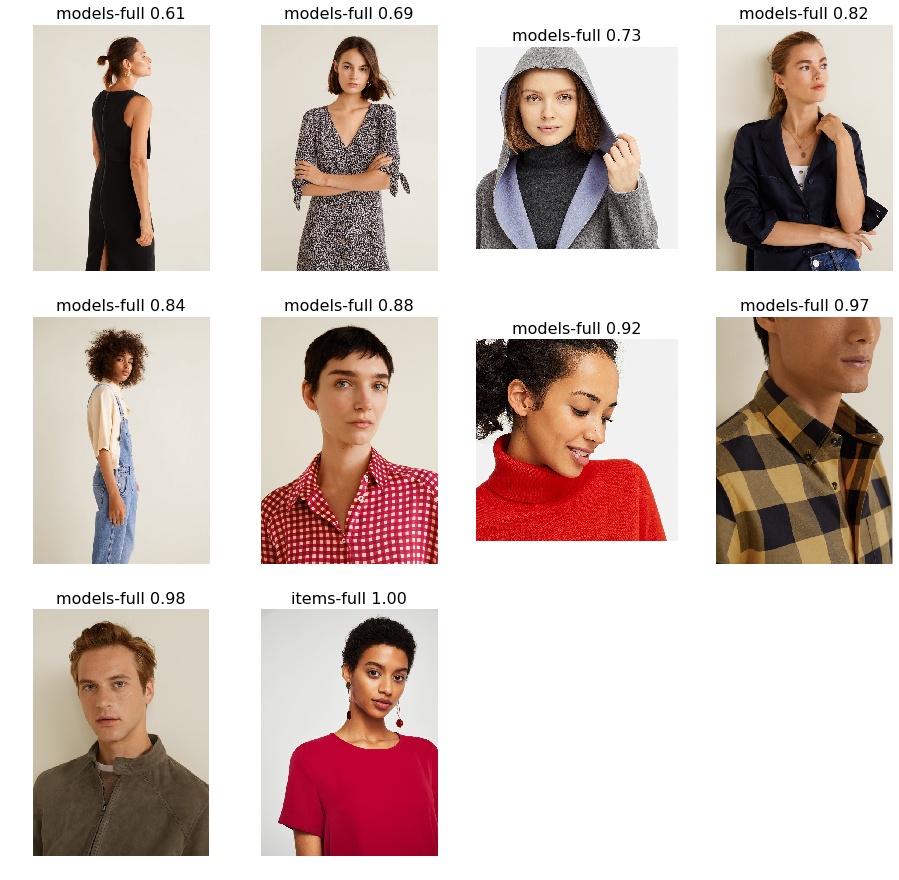

In [26]:
plot_most_incorrect(cat=1, n=40)

In [ ]:
def move_to_root(filepath_part):
    filename = os.path.split(filepath_part)[1]
    filepath = os.path.join(PATH, filepath_part)
    if os.path.exists(filepath):
        os.rename(filepath,
                  os.path.join(PATH, filename))

In [ ]:
# Move all errors of a category to the root folder to reasses if labeling is correct.
idxs = most_by_correct(1, False)
for idx in idxs:
    filename = data.val_ds.fnames[idx]
    print(filename, '{} {:.2f}'.format(data.classes[preds[idx]], probs[idx]))
    move_to_root(filename)

### More learning

In [27]:
learn.fit(lr, 2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.116267   0.055822   0.981178  
    1      0.074764   0.051768   0.983108                                                                              



[array([0.05177]), 0.9831081046561017]

In [28]:
learn.precompute = False

In [29]:
learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.156964   0.09902    0.967181  
    1      0.127333   0.098088   0.964286                                                                              



[array([0.09809]), 0.9642857092227715]

In [30]:
learn.save('resnext50_224_pre')

In [ ]:
learn.load('resnext50_224_pre')

## Increase size

In [40]:
# Starting training on small images for a few epochs, then switching to bigger images,
#  and continuing training is an amazingly effective way to avoid overfitting.

# set_data doesn’t change the model at all. It just gives it new data to train with.
learn.set_data(get_data(299, bs)) 
learn.freeze()

In [41]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.151226   0.073513   0.97626   
    1      0.156832   0.071863   0.976744                                                                              
    2      0.135048   0.074381   0.977229                                                                              



[array([0.07438]), 0.9772286784741305]

Validation loss is much lower than training loss. This is a sign of underfitting. Cycle_len=1 may be too short since the learning rate may be getting reset before it had the chance to zoom in properly. Let's set cycle_mult=2 to find better parameter.

In [42]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2) # 1+2+4 = 7 epochs

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.136131   0.073034   0.975775  
    1      0.139101   0.072207   0.979167                                                                              
    2      0.117448   0.073758   0.976744                                                                              
    3      0.12235    0.073805   0.975775                                                                              
    4      0.10319    0.077019   0.97626                                                                               
    5      0.12076    0.071217   0.977713                                                                              
    6      0.102922   0.073004   0.977229                                                                              



[array([0.073]), 0.9772286784741305]

In [44]:
learn.save('resnext50_299_pre')

In [51]:
learn.load('resnext50_299_pre')

In [45]:
learn.fit(lr, 1, cycle_len=2) # 1+1 = 2 epochs

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.114244   0.078887   0.975291  
    1      0.101162   0.072872   0.979167                                                                              



[array([0.07287]), 0.9791666622771773]

In [46]:
learn.save('resnext50_299_pre')

In [ ]:
log_preds = learn.predict()
probs = np.mean(np.exp(log_preds),0)
print('accuracy', accuracy_np(probs, y), 'loss', metrics.log_loss(y, probs))

## Unfreezing

In [50]:
learn.freeze()

In [47]:
learn.unfreeze()

In [48]:
lr_arr = np.array([lr / 100, lr / 10, lr])

In [49]:
learn.fit(lr_arr, 3, cycle_len=1, cycle_mult=2)  # 1 + 2 + 4 = 7 epochs

  0%|                                                                                          | 0/414 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (2) : out of memory at c:\anaconda2\conda-bld\pytorch_1519501749874\work\torch\lib\thc\generic/THCStorage.cu:58

Interestingly enough unfreezing seems to worsen the results. So the earlier layers were already finely tuned and we shouldn't mess with them in this short project.
Or, notice how the training loss is still higher than the validation loss, meaning we are underfitting. We can train further. But then again, the loss was already much lower before unfreezing.

In [ ]:
learn.save('resnext50_299_unfreeze')

## Confusion matrix

In [52]:
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)

RuntimeError: cuda runtime error (2) : out of memory at c:\anaconda2\conda-bld\pytorch_1519501749874\work\torch\lib\thc\generic/THCStorage.cu:58

In [ ]:
confusion_matrix = metrics.confusion_matrix(y, preds)
plot_confusion_matrix(confusion_matrix, data.classes)

## Individual prediction

In [ ]:
fn = data.val_ds.fnames[random.randint(0, len(data.val_ds.fnames))]
print(fn)
Image.open(os.path.join(PATH, fn)).resize((150, 150))

In [ ]:
# Method 1.
def predict_1(fn):
    trn_tfms, val_tfms = tfms_from_model(arch, sz)
    ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
    dl = DataLoader(ds)
    preds = learn.predict_dl(dl)
    return learn.data.classes[np.argmax(preds)]

In [ ]:
# Method 2.
def predict_2(fn):
    trn_tfms, val_tfms = tfms_from_model(arch, sz)
    im = val_tfms(open_image(os.path.join(PATH, fn)))  # open_image() returns numpy.ndarray
    preds = learn.predict_array(im[None])
    return learn.data.classes[np.argmax(preds)]

In [ ]:
f = plt.figure(figsize=(16, 8))
for i in range(12):
    fn = data.val_ds.fnames[random.randint(0, len(data.val_ds.fnames))]
    print(fn)
    title = fn.split('\\')[0][5:] + ' ' + predict_1(fn)
    sp = f.add_subplot(3, 4, i + 1)
    sp.axis('Off')
    sp.set_title(title, fontsize=14)
    plt.imshow(Image.open(os.path.join(PATH, fn)).resize((150, 150)))